# Time Series Demo: DCorr-X and MGC-X
In this notebook, we demonstrate the cross-distance correlation (`DCorrX`) test and the multiscale graph correlation for time series (`MGCX`) test for independence of time series.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import chi2
from scipy.io import savemat
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
import pickle

from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.benchmarks.ts_benchmarks import IndependentAR1, CorrelatedAR1, Nonlinear, EconometricProcess, NonlinearDependence, DynamicProcess

**Function to compute and print DCorrX nd MGCX output values, given X and Y. The `is_fast` parameter governs whether to use the fast appoximation.**

In [2]:
def compute_dcorrx(X, Y, max_lag):
    dcorrx = DCorrX(max_lag = max_lag, which_test = 'unbiased')
    dcorrx_statistic, metadata = dcorrx.test_statistic(X, Y)
    p_value, _ = dcorrx.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']

    print("DCorrX test statistic:", dcorrx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)

def compute_mgcx(X, Y, max_lag, is_fast = False):
    mgcx = MGCX(max_lag = max_lag)
    mgcx_statistic, metadata = mgcx.test_statistic(X, Y)
    p_value, _ = mgcx.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']
    optimal_scale = metadata['optimal_scale']
    
    print("MGCX test statistic:", mgcx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    print("Optimal Scale:", optimal_scale)

In [3]:
# Visualization of one dimensional X_t and Y_t
def plot_1d_ts(X, Y, title, xlab = "X_t", ylab = "Y_t"):
    """
    Method to plot univariate time series on the same figure.

    :param X: An ``[n*1]`` data matrix where ``n`` is the sample size.
    :type X: 2D ``numpy.array``

    :param Y: An ``[n*1]`` data matrix where ``n`` is the sample size.
    :type Y: 2D ``numpy.array``

    :param title: Plot title.
    :type title: string

    :param xlab: x-axis label.
    :type xlab: string

    :param ylab: y-axis label.
    :type ylab: string
    """
    n = X.shape[0]
    t = range(1, n + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    fig.suptitle(title)
    plt.rcParams.update({'font.size': 15})

    ax1.plot(t, X)
    ax1.plot(t, Y)
    ax1.legend(['X_t', 'Y_t'], loc = 'upper left', prop={'size': 12})
    ax1.set_xlabel("t")

    ax2.scatter(X,Y, color="red")
    ax2.set_ylabel(ylab)
    ax2.set_xlabel(xlab)

DCorrX test statistic: 0.006013890782504981
P Value: 0.446
Optimal Lag: 0
MGCX test statistic: 0.006188450732981778
P Value: 1.0
Optimal Lag: 0
Optimal Scale: [40, 40]


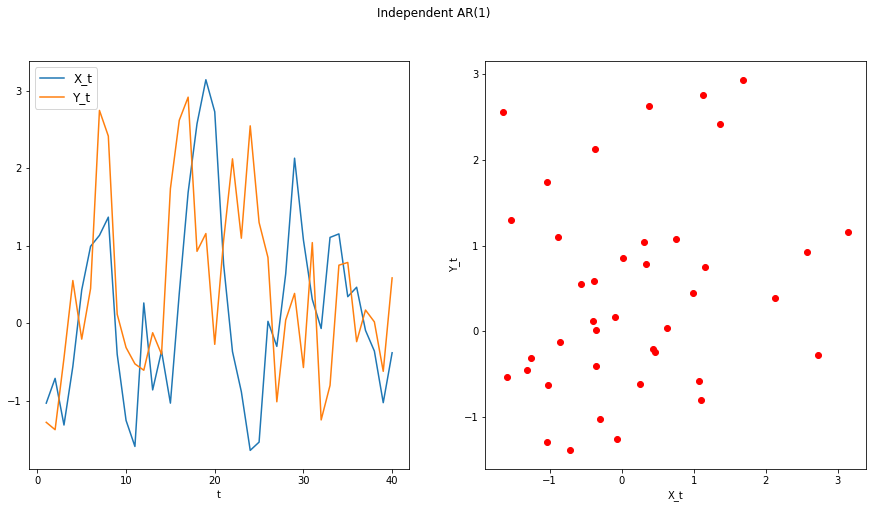

In [4]:
# Simulate data. X and Y are n-by-1 matrices. Should generally not reject, as X and Y are independent. Set the `is_fast` parameter to be True to use fast implementations.
n = 40
process = IndependentAR1()

X, Y = process.simulate(n)
plot_1d_ts(X, Y, title = process.name)

max_lag = 0
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag, is_fast = True)

**Example: simulate data `X` and `Y` in the form of `n`-by-`p` and `n`-by-`q` matrices respectively, where `n` is the sample size.** In the following cells, we simulate different time series processes and estimate the power of the test at varying choices of sample size. Additionally, we compare against the Ljung-Box test of correlation.

**Functions for plotting univarite time series and power curves for each of the processes.**

The following are helper functions.

In [40]:
def _compute_power(test, X_full, Y_full, num_sims, alpha, n):
    """
    Helper method estimate power of a test on a given simulation.

    :param test: Test to profile, either DCorrX or MGCX.
    :type test: TimeSeriesIndependenceTest

    :param X_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type X_full: 2D ``numpy.array``

    :param Y_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type Y_full: 2D ``numpy.array``

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param n: sample size.
    :type n: integer

    :return: returns the estimated power.
    :rtype: float
    """
    num_rejects = 0.0

    def worker(s):
        X = X_full[range(n), s]
        Y = Y_full[range(n), s]

        p_value, _ = test['object'].p_value(X, Y, is_fast = test['is_fast'])
        if p_value <= alpha:
            return 1.0
        return 0.0

    rejects = Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims))
    power = np.mean(rejects)
    std = np.std(rejects)

    return power, std

def _load_power_curves(tests, process):
    result = {}
    for test in tests:
        # Read in .pkl file.
        filename = "%s_powers_%s.pkl" % (test['filename'], process.filename)
        pickle_in = open(filename,"rb")
        curve = pickle.load(pickle_in)
        pickle_in.close()
        
        N = curve.shape[0]
        if not result:
            result['sample_sizes'] = curve[:,0].reshape((N, 1))
        result[test['filename'] + '_powers'] = curve[:,1].reshape((N, 1))
        result[test['filename'] + '_stds'] = curve[:,1].reshape((N, 1))
    return result

def _simulate_data(process, n_max, num_sims):
    # Store simulate processes.
    X_full = np.zeros((n_max, num_sims))
    Y_full = np.zeros((n_max, num_sims))
    for s in range(num_sims):
        X_full[:, s], Y_full[:, s] = process.simulate(n_max)
        
    # Save simulated output.
    output = {'X' : X_full, 'Y' : Y_full}
    filename = '%s_data.pkl' % process.filename
    file = open(filename, 'wb')
    pickle.dump(output, file)
    file.close()
    
    # Save to MATLAB format as well.
    savemat('%s_data.mat' % process.filename, {'X_full' : X_full, 'Y_full' : Y_full})

Similarly, the following are used in the rest of the demo to visualize the simulations.

In [47]:
def power_curve(tests, process, num_sims, alpha, sample_sizes, verbose = False):
    """
    Method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param verbose: whether to display output.
    :type verbose: boolean

    :param sample_sizes: range of sample sizes for which to estimate power.
    :type sample_sizes: 1-D array-like
    """
    # Load simulated processes.
    filename = "%s_data.pkl" % (process.filename)
    pickle_in = open(filename,"rb")
    data = pickle.load(pickle_in)
    pickle_in.close()
    X_full = data['X']
    Y_full = data['Y']
    N = len(sample_sizes)

    for test in tests:
        powers = np.zeros(N)
        stds = np.zeros(N)
        for i in range(N):
            n = sample_sizes[i]
            if verbose: print("Estimating power at sample size: %d" % n)
            powers[i], stds[i] = _compute_power(test, X_full, Y_full, num_sims, alpha, n)
        test['powers'] = powers
        test['stds'] = stds
        
        # Save powers output.
        output = np.concatenate((sample_sizes.reshape((N,1)), test['powers'].reshape((N,1)), test['stds'].reshape((N,1))), axis=1)
        filename = "%s_powers_%s.pkl" % (test['filename'], process.filename)
        file = open(filename, 'wb')
        pickle.dump(output, file)
        file.close()
        
def plot_power(tests, curves, alpha, process, plot_errors = True):
    """
    Helper method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param power_curve: range of sample sizes for which to estimate power.
    :type power_curve: 1-D array-like

    :param alpha: significance level.
    :type alpha: float

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess
    """
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots()
    plt.title(process.name)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    plt.ylim((-0.05, 1.05))

    for test in tests:
        sample_sizes = curves['sample_sizes']
        powers = curves[test['filename'] + '_powers']
        stds = curves[test['filename'] + '_stds']
        errs = 1.96*np.divide(stds, np.sqrt(sample_sizes)).reshape(len(stds),)
        plt.plot(sample_sizes, powers, linestyle = '-', color = test['color'])
        if plot_errors:
            plt.errorbar(sample_sizes, powers, yerr=errs, ecolor = test['color'])
    ax.legend([test['name'] for test in tests], loc = 'upper left', prop={'size': 12})

    ax.axhline(y = alpha, color = 'black', linestyle = '--')
    plt.show()

def plot_optimal_lags(optimal_lags, process, test, n, true_correlations = None, savefig = True):
    """
    Visualize distribution of optimal lag estimates. If the time series process is linear, then plot true cross correlations.

    :param optimal_lags: An array-like object containing optimal lag estimates from each simulation.
    :type optimal_lags: 1-D array-like

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess
    
    :param test: List of dictionaries with keys ['name', filename', 'object', 'color', 'optimal_lags'].
    :type test: list

    :param true_correlations: Array of size ``max_lag`` + 1, containing the cross correlation of ``X_{t}`` and ``Y_{t-j}`` for each ``j``.
    :type true_correlations: 1-D array-like

    :param savefig: Whether to save the figure. Defaults to True.
    :type savefig: boolean
    """
    plt.rcParams.update({'font.size': 14})
    
    plt.xlabel('Lag j')
    if true_correlations is not None:
        # True correlations of X_{t} and Y_{t-j}at various lags.
        plt.ylabel("Corr(X(t), Y(t-j)) / Freq. of Optimal Lag Estimates")

        j = range(true_correlations.shape[0])
        markerline, stemlines, baseline = plt.stem(j, true_correlations, '-k', use_line_collection = True)
        plt.setp(baseline, 'color', 'k', 'linewidth', 1)
        plt.setp(markerline, 'markerfacecolor', 'k')
    else:
        plt.ylabel("Freq. of Optimal Lag Estimates")
    
    # Optimal lab predictions.
    weights = np.ones_like(optimal_lags)/float(len(optimal_lags))
    plt.hist(optimal_lags, 
             bins = np.arange(test['object'].max_lag)-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = test['color'])
    
    title = '%s, %s, n = %d' % (test['name'], process.name, n)
    plt.title(title)
    if savefig:
        filename = "optimal_lags_%s_%s_%d.pdf" % (process.filename, test['filename'], n)
        plt.savefig(filename)
    plt.show()

**Power as a function of `n` of the tests on each process.** Probability of correctly rejecting the null hypothesis that the time series are independent.

**Full experiment, simulating the above time series, and counting the rejections and optimal lag detections by each test (as a function of `n`).**

In [42]:
max_lag = 1
num_sims = 100
alpha = 0.05
num_bootstrap = 100 # TO DO: Incorporate this parameter
sample_sizes = np.arange(10, 101, 10)
processes = [DynamicProcess()]

dcorrx = DCorrX(max_lag = max_lag)
mgcx = MGCX(max_lag = max_lag)

tests = [
    {
        'name' : 'DCorr-X',
        'filename' : 'dcorrx',
        'is_fast' : False,
        'subsample_size' : -1,
        'object' : dcorrx,
        'color' : 'blue',
    },
#     {
#         'name' : 'MGC-X',
#         'filename' : 'mgcx',
#         'is_fast' : False,
#         'object' : mgcx,
#         'color' : 'red',
#     },
]

In [43]:
# Simulating the data to be used by all processes.
for process in processes:
    _simulate_data(process, 1000, num_sims)

In [38]:
# Combining all time series simulations.
for process in processes:
    power_curve(tests, process, num_sims, alpha, sample_sizes)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 95 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of 100 | elapsed:    3.7s remaining:   33.0s
[Parallel(n_jobs=-2)]: Done  21 out of 100 | elapsed:    3.9s remaining:   14.6s
[Parallel(n_jobs=-2)]: Done  32 out of 100 | elapsed:    4.1s remaining:    8.6s
[Parallel(n_jobs=-2)]: Done  43 out of 100 | elapsed:    4.2s remaining:    5.5s
[Parallel(n_jobs=-2)]: Done  54 out of 100 | elapsed:    4.2s remaining:    3.6s
[Parallel(n_jobs=-2)]: Done  65 out of 100 | elapsed:    4.3s remaining:    2.3s
[Parallel(n_jobs=-2)]: Done  76 out of 100 | elapsed:    4.3s remaining:    1.4s
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    4.4s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done  98 out of 100 | elapsed:    6.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 95 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of 100 | e

[Parallel(n_jobs=-2)]: Done  54 out of 100 | elapsed:    9.7s remaining:    8.2s
[Parallel(n_jobs=-2)]: Done  65 out of 100 | elapsed:    9.8s remaining:    5.3s
[Parallel(n_jobs=-2)]: Done  76 out of 100 | elapsed:   10.0s remaining:    3.2s
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:   10.4s remaining:    1.5s
[Parallel(n_jobs=-2)]: Done  98 out of 100 | elapsed:   19.8s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   20.3s finished


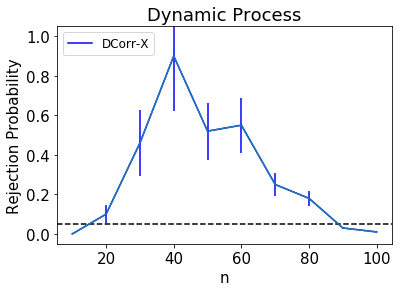

In [48]:
# Display.
tests = [
    {
        'name' : 'DCorr-X',
        'filename' : 'dcorrx',
        'is_fast' : False,
        'subsample_size' : -1,
        'object' : dcorrx,
        'color' : 'blue',
    },
#     {
#         'name' : 'MGC-X',
#         'filename' : 'mgcx',
#         'is_fast' : False,
#         'object' : mgcx,
#         'color' : 'red',
#     },
    # HSIC
    # Wild Bootstrap
]

for process in processes:
    curves = _load_power_curves(tests, process)
    plot_power(tests, curves, alpha, process)

**Analyzing the distribution of optimal lags returned by the tests.** We see how that the optimal lags returned by the test corresponds with the true dependence structure of the simulated time series.

In [ ]:
# Correlated AR(3)
phi_1 = 0.1
phi_3 = 0.8
max_lag = 10
num_sims = 100
sample_sizes = [15, 30, 60]

dcorrx = DCorrX(max_lag = max_lag)
mgcx = MGCX(max_lag = max_lag)

tests = [
    {
        'name' : 'DCorr-X',
        'filename' : 'dcorrx',
        'object' : dcorrx,
        'color' : 'blue',
        'optimal_lags' : np.zeros(num_sims)
    },
    {
        'name' : 'MGC-X',
        'filename' : 'mgcx',
        'object' : mgcx,
        'color' : 'red',
        'optimal_lags' : np.zeros(num_sims)
    },
]

# Determine true correlations.
rho_XY = np.zeros(max_lag + 1)
rho_X = np.zeros(max_lag + 1)
rho_X[0] = 1
rho_XY[1] = phi_1 / (1 - phi_3*(phi_1 + phi_3))
rho_X[2] = (phi_1 + phi_3)*rho_XY[1]
for j in range(3, max_lag + 1):
    if j%2:
        rho_XY[j] = phi_1*rho_X[j-1] + phi_3*rho_X[j-3]
    else:
        rho_X[j] = phi_1*rho_XY[j-1] + phi_3*rho_XY[j-3]
true_correlations = rho_XY

In [ ]:
dcorrx = DCorrX(max_lag = max_lag)
mgcx = MGCX(max_lag = max_lag)
corr = CorrelatedAR1()
corr.name = 'Correlated AR(3)'
corr.filename = 'corr_ar1'

# Store simulate processes.
n_full = np.max(sample_sizes)
X_full = np.zeros((n_full, num_sims))
Y_full = np.zeros((n_full, num_sims))
for s in range(num_sims):
    X_full[:, s], Y_full[:, s] = corr.simulate(n_full, phi_1 = phi_1, phi_3 = phi_3)

# Compute for each test and each sample, the optimal lag plot.
for test in tests:
    powers = np.zeros(len(sample_sizes))
    for n in sample_sizes:
        def worker(s):
            X = X_full[range(n), s]
            Y = Y_full[range(n), s]
            test_stat, metadata = test['object'].test_statistic(X, Y)
            return metadata['optimal_lag']

        test['optimal_lags'] = Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims))
        plot_optimal_lags(test['optimal_lags'], corr, test, n, true_correlations = true_correlations)

**Simulate a nonlinear process, and show that the optimal lag is correct for large n.**

In [ ]:
dcorrx = DCorrX(max_lag = max_lag)
mgcx = MGCX(max_lag = max_lag)
nonlin = Nonlinear(lag = 3)

# Compute for each test and each sample, the optimal lag plot.
for test in tests:
    powers = np.zeros(len(sample_sizes))
    for n in sample_sizes:
        def worker(s):
            X = X_full[range(n), s]
            Y = Y_full[range(n), s]
            test_stat, metadata = test['object'].test_statistic(X, Y)
            return metadata['optimal_lag']

        test['optimal_lags'] = Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims))
        plot_optimal_lags(test['optimal_lags'], nonlin, test, n)